In [17]:
import sys

sys.path.append('/Users/oscar/anaconda/envs/myenv/lib/python3.6/site-packages')

In [18]:
import cv2

In [222]:
from keras.applications import inception_v3
from keras.applications import vgg16
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
#model = inception_v3.InceptionV3(weights='imagenet',
                                 #include_top=False)
model = vgg16.VGG16(weights='imagenet', include_top=False)

In [212]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_283 (Conv2D)              (None, None, None, 32 864         input_9[0][0]                    
____________________________________________________________________________________________________
batch_normalization_283 (BatchNo (None, None, None, 32 96          conv2d_283[0][0]                 
____________________________________________________________________________________________________
activation_283 (Activation)      (None, None, None, 32 0           batch_normalization_283[0][0]    
___________________________________________________________________________________________

In [223]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
'''
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

layer_contributions = {
    'block2_conv2': 0.2,
    'block3_conv3': 3,
    'block4_conv3': 2.,
    'block5_conv2': 1.5,
}
'''
layer_contributions = {
    'block2_conv2': 0.2,
    'block3_conv3': 6.,
    'block4_conv3': 10.,
    'block5_conv3': 4.,
}


In [224]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [225]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [226]:
import scipy
from keras.preprocessing import image
import cv2
import random

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


# TODO: parameterize the amount of noise
def add_gaussian_noise(img, noise_sigma):
    noise_image = np.zeros(img.shape)
    noise_image = np.array([cv2.randn(noise_image[0],-0.1,0.1)])
    img = img + noise_image
    
    return img

# TODO: parameterize the amount of noise
def add_sp_noise(img):
    amount_of_noise = 0.002
    noise_percent = 100 * amount_of_noise
    num_p = np.ceil(amount_of_noise * img.shape[1] *img.shape[2] * 0.5)
    for mat in img:
        for i, row in enumerate(mat):
            for j, pixel in enumerate(row):
                r_int = random.randint(0, 10000)
                if r_int <= noise_percent * 100 * 0.5:
                    img[0][i][j][0] = 1
                    img[0][i][j][1] = 1
                    img[0][i][j][2] = 1
                r_int = random.randint(0, 10000)
                if r_int <= noise_percent * 100 * 0.5:
                    img[0][i][j][0] = -1
                    img[0][i][j][1] = -1
                    img[0][i][j][2] = -1

    return img


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def save_img_vgg(img, fname):
    pil_img = deprocess_image_vgg(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    #img = np.asarray(255*np.random.random((height, width, 3)), dtype='uint8')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    #img = vgg16.preprocess_input(img)
    return img

def preprocess_vgg(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = img.reshape((1, img.shape[0], image.shape[1], image.shape[2]))
    img = vgg19.preprocess_input(img)
    return img


# This one works for inception
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#this one works for VGG
# util function to convert a tensor into a valid image
def deprocess_image_vgg(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, x.shape[1], x.shape[2]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Processing image shape (204, 306)
...Loss value at 0 : 457.304
...Loss value at 1 : 480.402
...Loss value at 2 : 504.859
...Loss value at 3 : 530.456
...Loss value at 4 : 556.529
...Loss value at 5 : 583.458
...Loss value at 6 : 611.106
...Loss value at 7 : 638.601
...Loss value at 8 : 665.49
...Loss value at 9 : 692.243


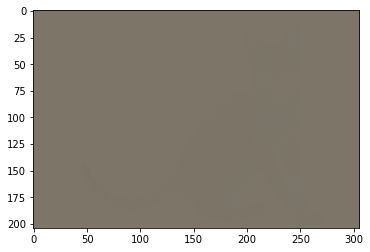

Processing image shape (285, 428)
...Loss value at 0 : 503.051
...Loss value at 1 : 531.378
...Loss value at 2 : 558.302
...Loss value at 3 : 584.903
...Loss value at 4 : 611.521
...Loss value at 5 : 638.226
...Loss value at 6 : 664.972
...Loss value at 7 : 691.845
...Loss value at 8 : 718.871
...Loss value at 9 : 746.021


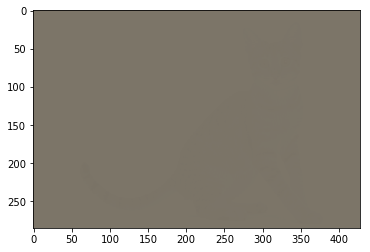

Processing image shape (400, 600)
...Loss value at 0 : 501.157
...Loss value at 1 : 531.811


KeyboardInterrupt: 

In [227]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.002  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 10  # Number of ascent steps per scale

noisy_sigma = 35

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = None

# Fill this to the path to the image you want to use
base_image_path = '/Users/oscar/Documents/Development/Resources/images/cat.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    #img = add_sp_noise(img)
    img = resize_img(img, shape)
    
    #img = add_gaussian_noise(img, noisy_sigma)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img_vgg(img, fname='vgg_cat_at_scale_' + str(shape) + '.png')
    plt.imshow(deprocess_image_vgg(np.copy(img)))
    plt.show()

save_img(img, fname='vgg_final_cat_dream.png')


In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

In [172]:
img = preprocess_image(base_image_path)
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='cat_dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_cat_noise_free_dream.png')

Processing image shape (645, 969)
...Loss value at 0 : 1.63522
...Loss value at 1 : 2.01985
...Loss value at 2 : 2.64353
...Loss value at 3 : 3.37098
...Loss value at 4 : 4.14693
...Loss value at 5 : 4.92538
...Loss value at 6 : 5.67643
...Loss value at 7 : 6.4113
...Loss value at 8 : 7.14837
...Loss value at 9 : 7.86537
...Loss value at 10 : 8.57295
...Loss value at 11 : 9.2486
...Loss value at 12 : 9.95099
Processing image shape (904, 1357)
...Loss value at 0 : 3.66091
...Loss value at 1 : 5.06846
...Loss value at 2 : 6.1919
...Loss value at 3 : 7.22262
...Loss value at 4 : 8.13363
...Loss value at 5 : 9.02438
...Loss value at 6 : 9.88125
Processing image shape (1266, 1900)
...Loss value at 0 : 3.67448
...Loss value at 1 : 4.97815
...Loss value at 2 : 6.14301
...Loss value at 3 : 7.19018
...Loss value at 4 : 8.20594
...Loss value at 5 : 9.23606
